### Task 1

We need to solve an inequality-constrained LP in 2 dimensions:

$$
\min_x p^Tx \quad x \in \mathbb{R}\\
\text{s.t.:} \quad Ax \le b
$$

Feasible set is a compact polygon that lies within $[-1, 1] \times [-1, 1]$.

I will solve the problem via barrier method. We will minimize $f_t(x) = t p^Tx - \sum \log(-A_ix + b_i)$ on each iteration, where $A_i$ is a $i^{th}$ row of A.

For this purpose I will use Newton method. Gradient and Hessian:

$$
\nabla f_t = tp - \sum_{i=1}^M \frac{A_i^T}{A_ix - b_i} \\
\Delta^2 f_t = \sum_{i=1}^M \frac{1}{\left( A_ix - b_i \right)^2}\begin{pmatrix} A_{i1}A_{i1} & A_{i1}A_{i2} \\ A_{i1}A_{i2} & A_{i2}A_{i2} \end{pmatrix}
$$

In [50]:
import numpy as np

def target_f(x):
    if np.any(-A.dot(x) + b <= 0):
        return np.inf
    else:
        return t * p.dot(x) - np.sum(np.log(-A.dot(x) + b))
    
def find_lmbda(fun, alpha=1.):
    while fun(alpha) == np.inf:
        alpha /= 2
    return alpha

def int_point_method(x, target_f, mu, lmbda, t):
    while A.shape[0] / t >= eps: # Slackness M / t >= eps - stopping criteria 
        hessian = np.eye(2) * 0
        grad = t*p - np.sum(A.T / np.atleast_2d((A.dot(x) - b)), axis=1)
        for i in range(A.shape[0]):
            hessian = hessian + 1. / (A[i, :].dot(x) - b[i])**2 * np.array([[A[i, 0] * A[i, 0], A[i, 0] * A[i, 1]], [A[i, 0] * A[i, 1], A[i, 1] * A[i, 1]]])
        lmbda = find_lmbda(lambda alpha: target_f(x - alpha * np.linalg.lstsq(hessian, grad)[0]))
        x = x - lmbda * np.linalg.lstsq(hessian, grad)[0]
        x_steps.append(x)
        t = mu * t
    return x

In [76]:
x0 = np.array([0, 0]) # feasible starting point
mu = 1.1
t = 1
lmbda = 0.1
eps = 1e-3

p = np.array([1, 3])
A = np.array([[0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1]])
b = np.array([1, 1, 0.75, 0.75, 0.75, 0.75])

x0 = np.array([0, 0])
x_steps = [x0]
    
x = int_point_method(x0, target_f, mu, lmbda, t)
print 'Optimal value:', p.dot(x)
print 'Optimal x:', x

Optimal value: -2.24966057104
Optimal x: [ -4.24342256e-05  -7.49872712e-01]


Let's check that our algorithm performs well:

In [77]:
import cvxpy as cvx
import gurobi

x = cvx.Variable(2)

constraints = [A * x <= b]

obj = cvx.Minimize(p * x)

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI')
print 'Optimal value:', prob.value
print 'Optimal x: \n', x.value

Optimal value: -2.25
Optimal x: 
[[ 0.  ]
 [-0.75]]


As we can see, the result is acceptable.

Let's visualize the progress of the interior-point method towards the optimum:

Populating the interactive namespace from numpy and matplotlib


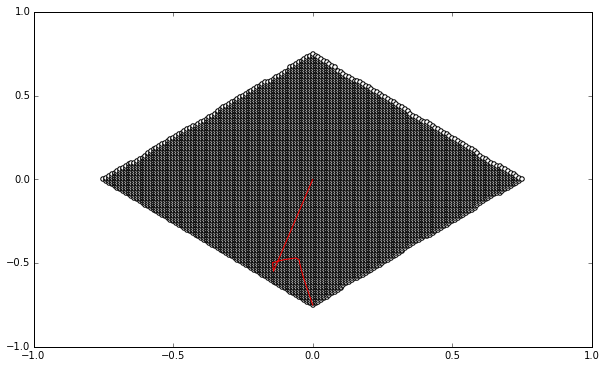

In [67]:
from matplotlib import pyplot as plt
%pylab inline

x1, x2 = np.mgrid[-1:1:0.01, -1:1:0.01]
feasible = np.repeat(False, x1.shape[0] * x1.shape[1]).reshape(x1.shape)
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        feasible[i, j] = np.all(A.dot([x1[i, j], x2[i, j]]) - b <= 0)

fig = plt.figure(figsize=(10, 6))
plt.scatter(x1[feasible], x2[feasible], c='1')
plt.plot(*zip(*x_steps), c='r')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

Let's try different $p, A, b$:

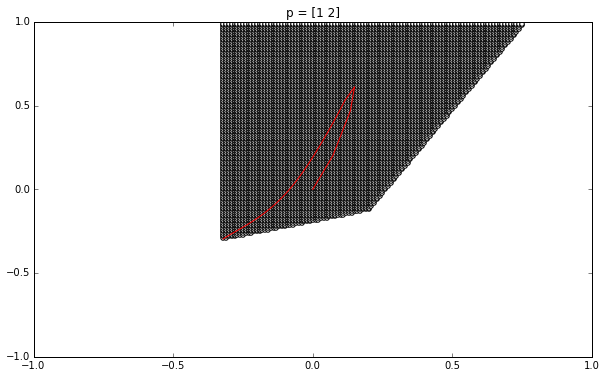

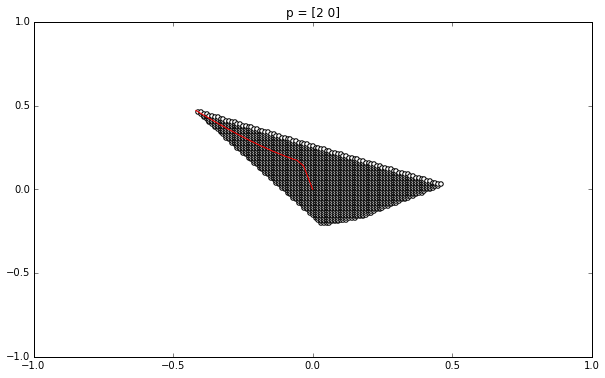

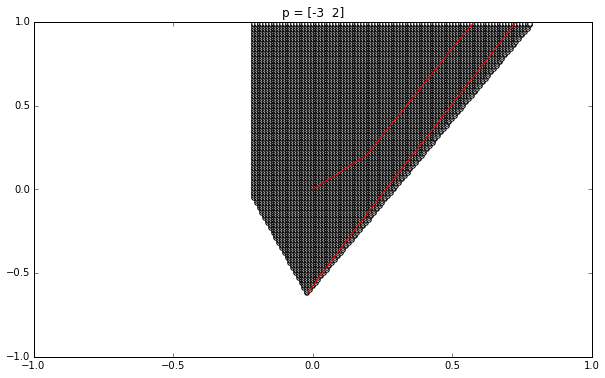

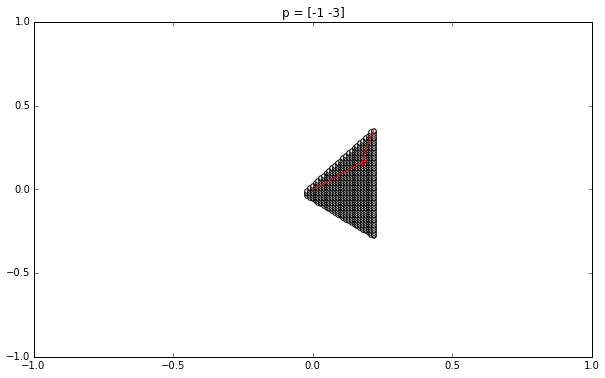

In [82]:
x0 = np.array([0, 0]) # feasible starting point
mu = 1.1
t = 1
lmbda = 0.1
eps = 1e-3
n = 5

for i in range(4):
    np.random.seed(i)   
    p = np.random.randint(-3, 3, 2)
    A = np.random.randint(-3, 3, (n,2))
    b = np.random.rand(n)
    
    x_steps = [x0]
    
    x = int_point_method(x0, target_f, mu, lmbda, t)
    
    x1, x2 = np.mgrid[-1:1:0.01, -1:1:0.01]
    feasible = np.repeat(False, x1.shape[0] * x1.shape[1]).reshape(x1.shape)
    for i in range(x1.shape[0]):
        for j in range(x1.shape[1]):
            feasible[i, j] = np.all(A.dot([x1[i, j], x2[i, j]]) - b <= 0)

    fig = plt.figure(figsize=(10, 6))
    plt.title('p = %s'%p)
    plt.scatter(x1[feasible], x2[feasible], c='1')
    plt.plot(*zip(*x_steps), c='r')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

### Task 2

We need to reduce our problem to maxflow problem. Actually, I will work with mincut problem.

$$
\min_{x} \sum_{i=1}^N E_i(x_i) + \sum_{i,j=1}^N E_{ij}(x_i, x_j) \\
\text{s.t.:} \quad x_i \in \{0,1\}
$$

Here $E_i(1) = c_i$ (cost of depot opening in city $i$), $E_{i,j}(1,1) = -p_{ij}$ (profit of operating on the segment between cities $i$ and $j$). Everything else equals $0$.

I will act as it was said in the lectures: 1) I will add two vertices - source $(N+1)$ and sink $(N+2)$; 2) Arcs between the source and each of the vertices will be added with capacity $u_{N+1 i} = c_i$; 3) Arcs with $u_{ij} = p_{ij}$ will be added for each railroad between cities $i$ and $j$. An arc from city $j$ to the sink with capacity $u_{j N+2} = \sum_{i=1}^N p_{ij}$ will be added as well.

The problem will look then as follows:

$$
\min_{x} \sum_{i,j=1}^{N+2} u_{i,j}(x_j - x_i)_{+} \\
\text{s.t.:} \quad x_{N+1} = 0 \\
x_{N+2} = 1 \\
x_i \in \{0,1\} \quad \forall i \in \overline{1,N}
$$

Now we have a mincut problem.

In [1]:
def GetMatrix(links,cities):

    A = np.zeros((len(cities), len(cities)));
    for i in xrange(0, len(links), 3):
        A[cities.index(links[i]), cities.index(links[i + 1])] =  links[i+2]
           
    return A        

In [2]:
import numpy as np
cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago','Dallas', 
          'Denver', 'Duluth', 'ElPaso','Helena', 'Houston', 'KansasCity', 'LasVegas',
          'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 'Nashville',
          'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix',
          'Pittsburgh', 'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity',
          'SanFrancisco','SantaFe', 'SaultStMarie', 'Seattle', 'Toronto',
          'Vancouver', 'Washington', 'Winnipeg'];

blue = ['Winnipeg','Helena',4,
    'Portland','SaltLakeCity',6,
    'Omaha','Chicago',4,
    'Montreal','NewYork',3,
    'KansasCity','SaintLouis',2,
    'SantaFe','OklahomaCity',3,
    'Atlanta','Miami',5];

blue = GetMatrix(blue,cities);

white = ['Calgary','Winnipeg',6,
    'Chicago','Toronto',4,
    'SaintLouis','Chicago',2,
    'Pittsburgh','NewYork',2,
    'SanFrancisco','SaltLakeCity',5,
    'Phoenix','Denver',5,
    'LittleRock','Nashville',3];

white = GetMatrix(white,cities);

green = ['Portland','SanFrancisco',5,
    'Helena','Denver',4,
    'SaintLouis','Pittsburgh',5,
    'LittleRock','NewOrleans',3,
    'ElPaso','Houston',6];

green = GetMatrix(green,cities);

red = ['Helena','Omaha',5,
    'Denver','OklahomaCity',4,
    'ElPaso','Dallas',4,
    'NewOrleans','Miami',6,
    'NewYork','Boston',2,
    'Duluth','Chicago',3];

red = GetMatrix(red,cities);

purple = ['Helena','SaltLakeCity',3,
    'Denver','Omaha',4,
    'Duluth','Toronto',6,
    'Charleston','Miami',4,
    'SanFrancisco','LosAngeles',3];
purple = GetMatrix(purple,cities);

orange = ['LasVegas','SaltLakeCity',3,
    'Helena','Duluth',6,
    'Chicago','Pittsburgh',3,
    'Denver','KansasCity',4,
    'NewYork','Washington',2,
    'Atlanta','NewOrleans',4];

orange = GetMatrix(orange,cities);

black = ['LosAngeles','ElPaso',6,
    'Winnipeg','Duluth',4,
    'SaultStMarie','Montreal',5,
    'Nashville','Raleigh',3];

black = GetMatrix(black,cities);

yellow = ['Seattle','Helena',6,
    'ElPaso','OklahomaCity',5,
    'Nashville','Pittsburgh',4];

yellow = GetMatrix(yellow,cities);

gray = ['Vancouver','Seattle',1,
    'Portland','Seattle',1,
    'Vancouver','Calgary',3,
    'Seattle','Calgary',4,
    'Calgary','Helena',4,
    'Winnipeg','SaultStMarie',6,
    'Duluth','SaultStMarie',3,
    'SaultStMarie','Toronto',2,
    'Toronto','Montreal',3,
    'Montreal','Boston',2,
    'Toronto','Pittsburgh',2,
    'LasVegas','LosAngeles',2,
    'LosAngeles','Phoenix',3,
    'Phoenix','ElPaso',3,
    'ElPaso','SantaFe',2,
    'Phoenix','SantaFe',3,
    'SantaFe','Denver',2,
    'Duluth','Omaha',2,
    'Omaha','KansasCity',1,
    'KansasCity','OklahomaCity',2,
    'OklahomaCity','Dallas',2,
    'Dallas','Houston',1,
    'Houston','NewOrleans',2,
    'Dallas','LittleRock',2,
    'OklahomaCity','LittleRock',2,
    'LittleRock','SaintLouis',2,
    'SaintLouis','Nashville',2,
    'Nashville','Atlanta',1,
    'Atlanta','Charleston',2,
    'Charleston','Raleigh',2,
    'Atlanta','Raleigh',2,
    'Raleigh','Washington',2,
    'Raleigh','Pittsburgh',2,
    'Washington','Pittsburgh',2];

gray = GetMatrix(gray,cities);

profit = blue*1.0+white*1.5+green*2.0+red*2.0+purple*2.5+orange*1.0+black*1.0+yellow*2.0+gray*1.0;

#TODO: symmetrize the matrix if necessary by uncommenting the next line
profit_sym = np.dstack([profit, profit.transpose()]).max(axis=2)

costs = np.ones((len(cities),1))*10;

#TODO put your solution here

In [21]:
import cvxpy as cvx
import gurobi
import numpy as np

u = np.zeros((profit.shape[0] + 2, profit.shape[1] + 2))
u[0, 1:-1] = costs.reshape((-1,))
u[1:-1, 1:-1] = profit
u[1:-1, -1] = np.sum(profit, axis=0)

x = cvx.Variable(costs.shape[0] + 2)
        
constraints = [x[0] == 0,
              x[-1] == 1,
              x >= 0,
              x <= 1]

obj = cvx.Minimize(np.sum([u[i,j] * cvx.pos(x[j] - x[i]) for j in range(costs.shape[0] + 2) for i in range(costs.shape[0] + 2)]))

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI')

ind = np.argwhere(x.value == 1.)[:-1, 0] - 1
print 'Depots opened:', (len(costs[ind])), '\n'
for i in ind:
    print cities[i]

Depots opened: 27 

Atlanta
Calgary
Charleston
Chicago
Dallas
Denver
Duluth
ElPaso
Helena
Houston
LittleRock
LosAngeles
Miami
Nashville
NewOrleans
OklahomaCity
Omaha
Phoenix
Pittsburgh
Portland
SaintLouis
SaltLakeCity
SanFrancisco
SaultStMarie
Seattle
Toronto
Winnipeg


The profit will be then:

In [13]:
-sum(costs[ind]) + np.sum(profit[i, j] for j in ind for i in ind)

array([ 25.5])

The map:

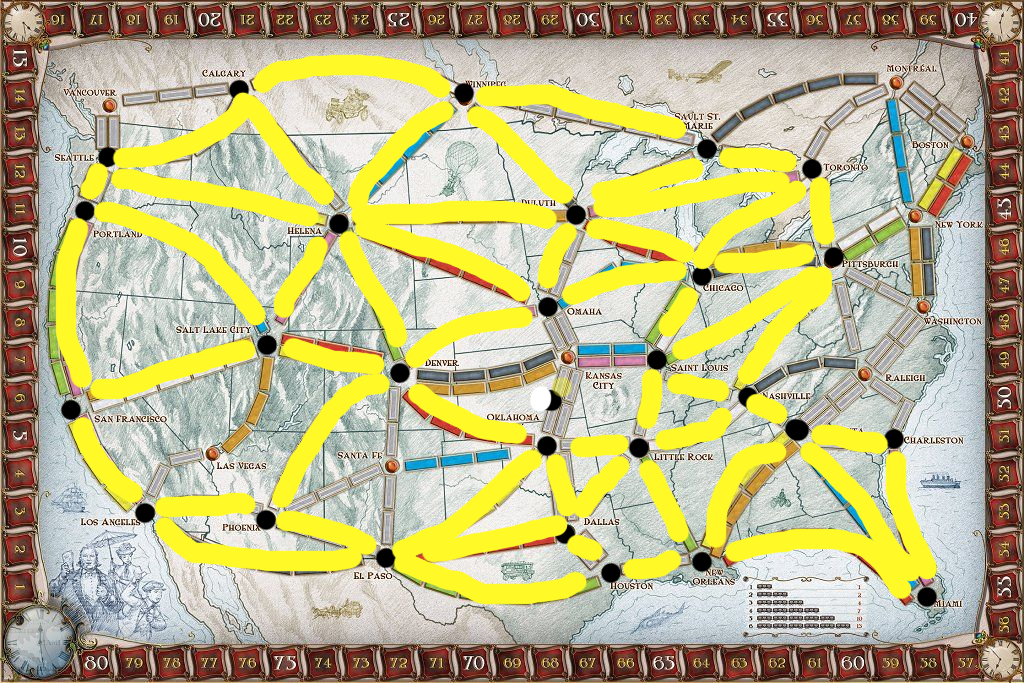

In [19]:
from IPython.display import Image
Image(filename='TicketToRide3.png')